In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.model_selection import train_test_split

csv_path = "ufo_sightings_1900_2024.csv"
df = pd.read_csv(csv_path)

print("Raw shape:", df.shape)
print(df.head())
print(df.info())

# ----------------------------
# Fix date parsing
# ----------------------------
# Your strings look like "15-01-1965" (DD-MM-YYYY)
# Use dayfirst=True and DO NOT pass a format first
df["date"] = pd.to_datetime(
    df["date"],
    dayfirst=True,      # important for dd-mm-yyyy
    errors="coerce"
)

print("\nAfter parsing dates:")
print(df["date"].head())
print("NaT count:", df["date"].isna().sum())

# Drop rows where date is NaT (should be very few now)
df = df.dropna(subset=["date"]).copy()
print("Shape after dropping invalid dates:", df.shape)

# ----------------------------
# Time features
# ----------------------------
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["year_month"] = df["date"].dt.to_period("M").astype(str)

# ----------------------------
# Clean other fields
# ----------------------------
if "location" in df.columns:
    df["location"] = df["location"].astype(str).str.strip()

for col in ["duration_seconds", "nearest_airport_distance_km"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

print("\nMissing values per column:")
print(df.isna().sum())

print("\nSample after cleaning:")
print(df.head())


Raw shape: (100000, 9)
   sighting_id        date   location     shape  duration_seconds  \
0            1  1965-01-15     Brazil       Orb              2209   
1            2  1960-02-16  Australia  Triangle              3415   
2            3  1966-12-10         UK      Disc               313   
3            4  1928-05-13      India   Unknown              1710   
4            5  1949-10-20     Brazil  Cylinder              2471   

                          description  nearest_airport_distance_km evidence  \
0  Mysterious bright light in the sky                          218      Yes   
1  Mysterious bright light in the sky                           58      Yes   
2  Mysterious bright light in the sky                          325      Yes   
3  Mysterious bright light in the sky                           93       No   
4  Mysterious bright light in the sky                          103       No   

   credibility_score  
0               9.95  
1               7.08  
2               3.

/tmp/ipython-input-4192081232.py:20: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df["date"] = pd.to_datetime(



After parsing dates:
0   1965-01-15
1   1960-02-16
2   1966-12-10
3   1928-05-13
4   1949-10-20
Name: date, dtype: datetime64[ns]
NaT count: 0
Shape after dropping invalid dates: (100000, 9)

Missing values per column:
sighting_id                    0
date                           0
location                       0
shape                          0
duration_seconds               0
description                    0
nearest_airport_distance_km    0
evidence                       0
credibility_score              0
year                           0
month                          0
year_month                     0
dtype: int64

Sample after cleaning:
   sighting_id       date   location     shape  duration_seconds  \
0            1 1965-01-15     Brazil       Orb              2209   
1            2 1960-02-16  Australia  Triangle              3415   
2            3 1966-12-10         UK      Disc               313   
3            4 1928-05-13      India   Unknown              1710   
4      

In [2]:
# Treat 'location' as region
df["region"] = df["location"].astype(str).str.strip()

# Monthly counts per region
monthly_region = (
    df.groupby(["region", "year_month"])
      .agg(
          sightings_count=("sighting_id", "count"),
          avg_duration_sec=("duration_seconds", "mean"),
          avg_credibility=("credibility_score", "mean"),
          avg_airport_dist_km=("nearest_airport_distance_km", "mean")
      )
      .reset_index()
)

print("monthly_region shape:", monthly_region.shape)
print(monthly_region.head())

# Global monthly series (all regions together)
monthly_global = (
    df.groupby("year_month")["sighting_id"]
      .count()
      .reset_index(name="sightings_count")
)

print("monthly_global shape:", monthly_global.shape)
print(monthly_global.head())


monthly_region shape: (11997, 6)
      region year_month  sightings_count  avg_duration_sec  avg_credibility  \
0  Australia    1900-01                6       1545.833333         5.713333   
1  Australia    1900-02                4       1537.250000         3.815000   
2  Australia    1900-03                8       1197.125000         5.616250   
3  Australia    1900-04                4       1722.750000         6.282500   
4  Australia    1900-05                4       2082.500000         3.435000   

   avg_airport_dist_km  
0               335.50  
1               384.00  
2               233.25  
3               222.00  
4               247.75  
monthly_global shape: (1500, 2)
  year_month  sightings_count
0    1900-01               61
1    1900-02               57
2    1900-03               73
3    1900-04               71
4    1900-05               63


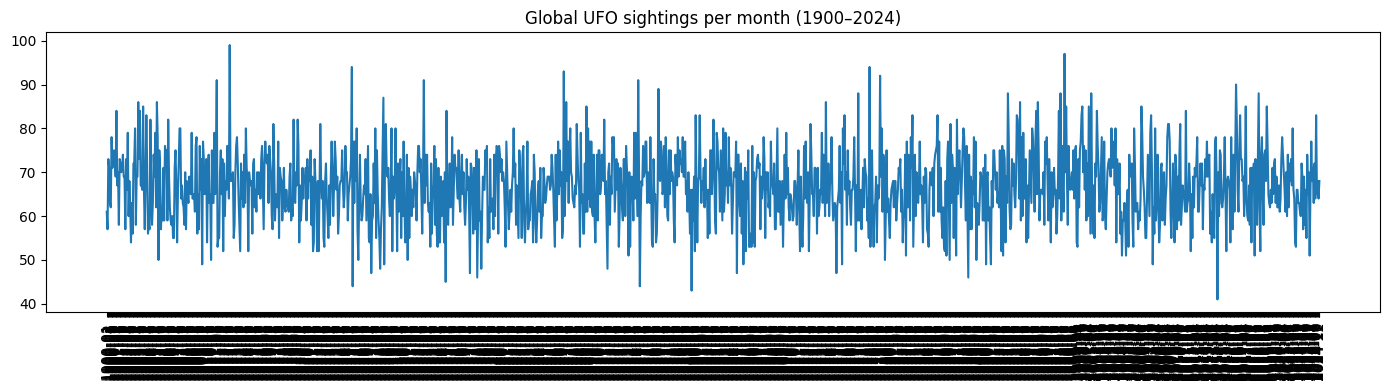

In [3]:
import matplotlib.pyplot as plt

# Global timeline
plt.figure(figsize=(14,4))
monthly_global_sorted = monthly_global.sort_values("year_month")
plt.plot(monthly_global_sorted["year_month"], monthly_global_sorted["sightings_count"])
plt.xticks(rotation=90)
plt.title("Global UFO sightings per month (1900–2024)")
plt.tight_layout()
plt.show()


In [4]:
import numpy as np

# Pivot to get matrix: rows = year_month, columns = regions
pivot = monthly_region.pivot(
    index="year_month",
    columns="region",
    values="sightings_count"
).fillna(0)

print(pivot.shape)
print(pivot.head())


(1500, 8)
region      Australia  Brazil  Canada  China  Germany  India    UK   USA
year_month                                                              
1900-01           6.0     5.0     3.0    9.0     13.0   11.0   7.0   7.0
1900-02           4.0     4.0    11.0   10.0      6.0   10.0   7.0   5.0
1900-03           8.0     7.0     7.0   11.0      9.0   10.0   8.0  13.0
1900-04           4.0    11.0     8.0    9.0     12.0    5.0  13.0   9.0
1900-05           4.0     6.0     6.0    8.0      9.0   11.0  10.0   9.0


In [8]:
import numpy as np
import networkx as nx

# Start from corr_matrix you printed
corr_abs = corr_matrix.abs()
np.fill_diagonal(corr_abs.values, 0)

G = nx.Graph()
regions = corr_abs.columns.tolist()

# CREATE region_stats DataFrame first (this was missing!)
region_stats = (
    monthly_region
    .groupby("region")
    .agg(
        total_sightings=("sightings_count", "sum"),
        mean_credibility=("avg_credibility", "mean"),
        mean_duration_sec=("avg_duration_sec", "mean"),
        mean_airport_dist_km=("avg_airport_dist_km", "mean")
    )
)

# Add nodes with attributes
for region in regions:
    stats = region_stats.loc[region]
    G.add_node(
        region,
        total_sightings=float(stats["total_sightings"]),
        mean_credibility=float(stats["mean_credibility"]),
        mean_duration_sec=float(stats["mean_duration_sec"]),
        mean_airport_dist_km=float(stats["mean_airport_dist_km"])
    )

# Very low threshold because correlations are tiny
threshold = 0.01   # keep edges where |corr| >= 0.01

for i, r1 in enumerate(regions):
    for j, r2 in enumerate(regions):
        if j <= i:
            continue
        weight = corr_abs.iloc[i, j]
        if weight >= threshold:
            G.add_edge(r1, r2, weight=float(weight))

print("Graph nodes:", G.number_of_nodes())
print("Graph edges:", G.number_of_edges())


Graph nodes: 8
Graph edges: 18


In [12]:
from networkx.algorithms.community import louvain_communities

deg_centrality = nx.degree_centrality(G)
weighted_degree = {
    node: sum(d["weight"] for _, _, d in G.edges(node, data=True))
    for node in G.nodes()
}
betweenness = nx.betweenness_centrality(G, weight="weight", normalized=True)
pagerank = nx.pagerank(G, weight="weight")

communities = louvain_communities(G, weight="weight", seed=42)
community_map = {}
for cid, comm in enumerate(communities):
    for node in comm:
        community_map[node] = cid

graph_features = pd.DataFrame({
    "region": list(G.nodes()),
    "degree_centrality": [deg_centrality[r] for r in G.nodes()],
    "weighted_degree": [weighted_degree[r] for r in G.nodes()],
    "betweenness": [betweenness[r] for r in G.nodes()],
    "pagerank": [pagerank[r] for r in G.nodes()],
    "community_id": [community_map[r] for r in G.nodes()]
})

print(graph_features)

monthly_region_g = monthly_region.merge(graph_features, on="region", how="left")
print("\nCreated monthly_region_g shape:", monthly_region_g.shape)


      region  degree_centrality  weighted_degree  betweenness  pagerank  \
0  Australia           0.428571         0.097171     0.000000  0.091555   
1     Brazil           0.571429         0.068469     0.333333  0.071777   
2     Canada           0.428571         0.126986     0.000000  0.114259   
3      China           0.714286         0.120031     0.571429  0.113597   
4    Germany           1.000000         0.272956     0.047619  0.235155   
5      India           1.000000         0.213319     0.380952  0.190642   
6         UK           0.571429         0.088968     0.000000  0.088215   
7        USA           0.428571         0.099637     0.000000  0.094800   

   community_id  
0             0  
1             1  
2             0  
3             1  
4             0  
5             1  
6             1  
7             1  

Created monthly_region_g shape: (11997, 11)


In [13]:
# Sort consistently
monthly_region_g = monthly_region_g.sort_values(["region", "year_month"]).reset_index(drop=True)

# Convert year_month string -> timestamp (use first day of month)
monthly_region_g["ds"] = pd.to_datetime(monthly_region_g["year_month"], format="%Y-%m")

# Add explicit numeric time features
monthly_region_g["year"] = monthly_region_g["ds"].dt.year
monthly_region_g["month_num"] = monthly_region_g["ds"].dt.month

print(monthly_region_g[["region", "year_month", "ds", "year", "month_num"]].head())


      region year_month         ds  year  month_num
0  Australia    1900-01 1900-01-01  1900          1
1  Australia    1900-02 1900-02-01  1900          2
2  Australia    1900-03 1900-03-01  1900          3
3  Australia    1900-04 1900-04-01  1900          4
4  Australia    1900-05 1900-05-01  1900          5


In [14]:
max_lag = 3  # you can later try 6, 12, etc.

for lag in range(1, max_lag + 1):
    monthly_region_g[f"lag_{lag}"] = (
        monthly_region_g
        .groupby("region")["sightings_count"]
        .shift(lag)
    )

# Remove rows where lags are missing (first 3 months per region)
lag_cols = [f"lag_{l}" for l in range(1, max_lag + 1)]
monthly_region_g = monthly_region_g.dropna(subset=lag_cols).reset_index(drop=True)

print(monthly_region_g[["region", "year_month", "sightings_count"] + lag_cols].head())


      region year_month  sightings_count  lag_1  lag_2  lag_3
0  Australia    1900-04                4    8.0    4.0    6.0
1  Australia    1900-05                4    4.0    8.0    4.0
2  Australia    1900-06                8    4.0    4.0    8.0
3  Australia    1900-07               11    8.0    4.0    4.0
4  Australia    1900-08                7   11.0    8.0    4.0


In [15]:
train_end_year = 2015
val_end_year = 2019

train_mask = monthly_region_g["year"] <= train_end_year
val_mask   = (monthly_region_g["year"] > train_end_year) & (monthly_region_g["year"] <= val_end_year)
test_mask  = monthly_region_g["year"] > val_end_year

feature_cols = [
    "lag_1", "lag_2", "lag_3",
    "avg_duration_sec", "avg_credibility", "avg_airport_dist_km",
    "degree_centrality", "weighted_degree", "betweenness", "pagerank",
    "month_num", "year"
]

target_col = "sightings_count"

X_train = monthly_region_g.loc[train_mask, feature_cols]
y_train = monthly_region_g.loc[train_mask, target_col]

X_val   = monthly_region_g.loc[val_mask, feature_cols]
y_val   = monthly_region_g.loc[val_mask, target_col]

X_test  = monthly_region_g.loc[test_mask, feature_cols]
y_test  = monthly_region_g.loc[test_mask, target_col]

print("Shapes ->", X_train.shape, X_val.shape, X_test.shape)


Shapes -> (11109, 12) (384, 12) (480, 12)


In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

def eval_model(model, X, y, name):
    preds = model.predict(X)
    mae = mean_absolute_error(y, preds)
    # For older sklearn: no 'squared' argument -> compute RMSE manually
    mse = mean_squared_error(y, preds)
    rmse = np.sqrt(mse)
    print(f"{name} -> MAE: {mae:.3f}, RMSE: {rmse:.3f}")
    return preds

train_preds = eval_model(rf, X_train, y_train, "Train")
val_preds   = eval_model(rf, X_val,   y_val,   "Val")
test_preds  = eval_model(rf, X_test,  y_test,  "Test")


Train -> MAE: 0.781, RMSE: 0.989
Val -> MAE: 2.293, RMSE: 2.888
Test -> MAE: 2.022, RMSE: 2.517



=== FEATURE IMPORTANCE ===
                feature  importance
4       avg_credibility    0.194711
3      avg_duration_sec    0.187117
5   avg_airport_dist_km    0.179410
11                 year    0.104571
2                 lag_3    0.068416
0                 lag_1    0.063479
1                 lag_2    0.062731
10            month_num    0.061438
7       weighted_degree    0.022375
9              pagerank    0.022142
8           betweenness    0.020392
6     degree_centrality    0.013219


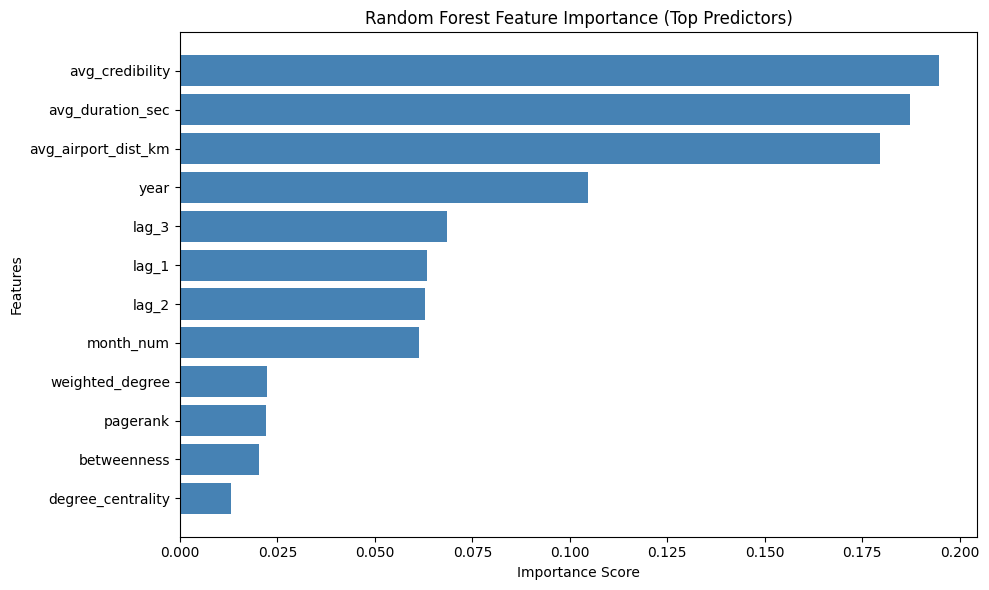


Top 3 features explain 56.12% of variance

=== RESIDUAL STATISTICS ===
Train Residuals - Mean: -0.018, Std: 0.988
Val Residuals   - Mean: -0.173, Std: 2.886
Test Residuals  - Mean: -0.306, Std: 2.501


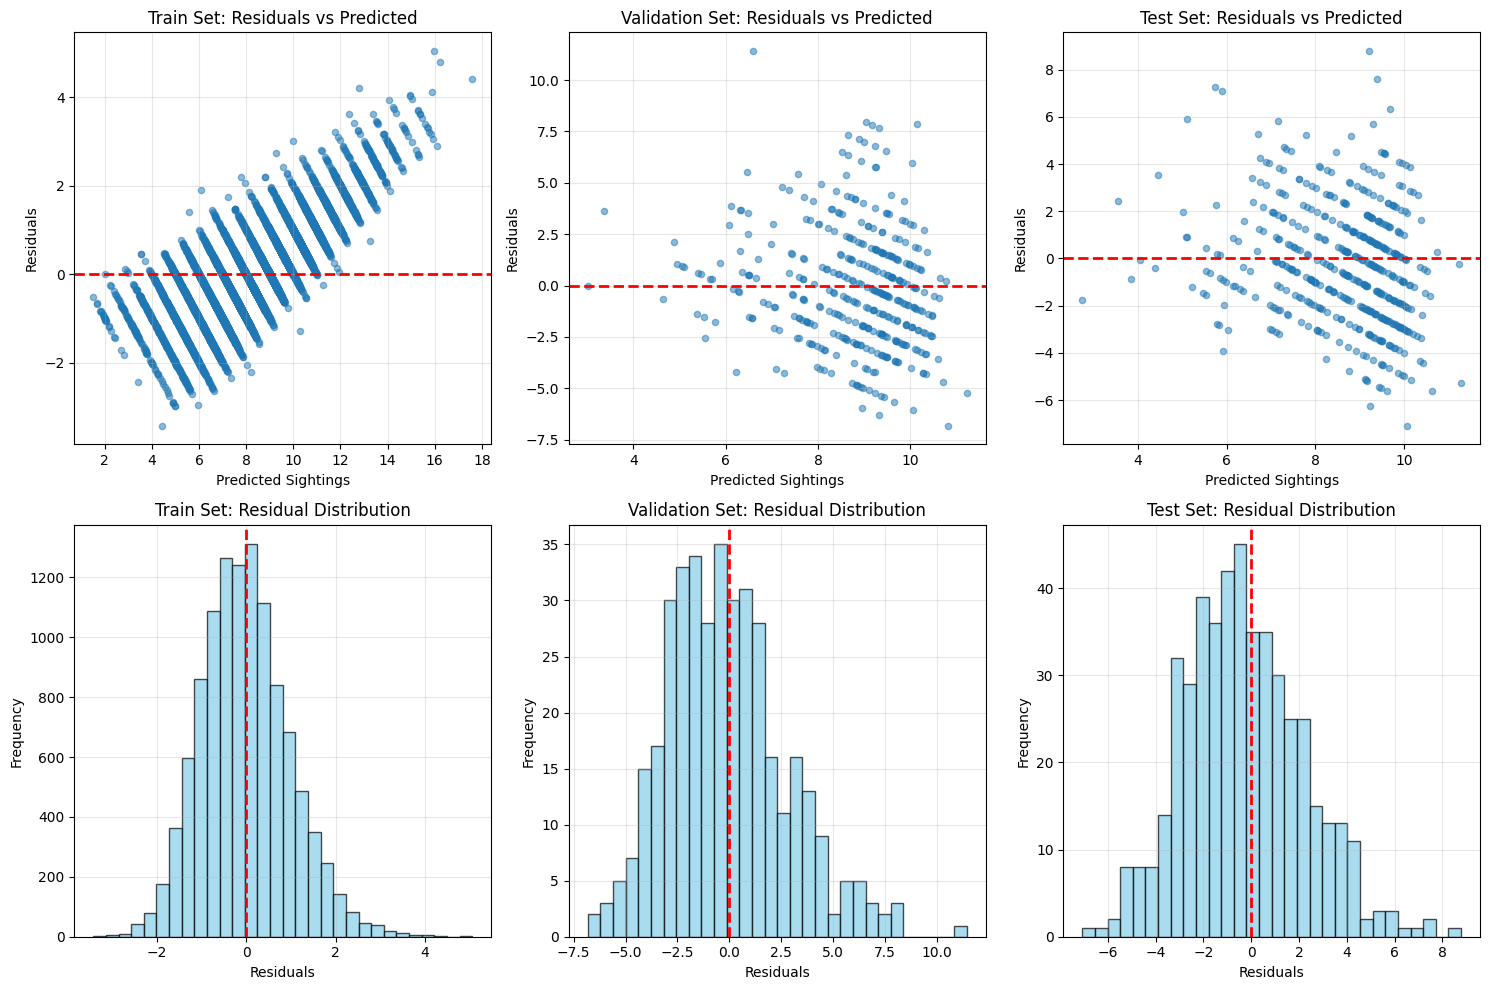

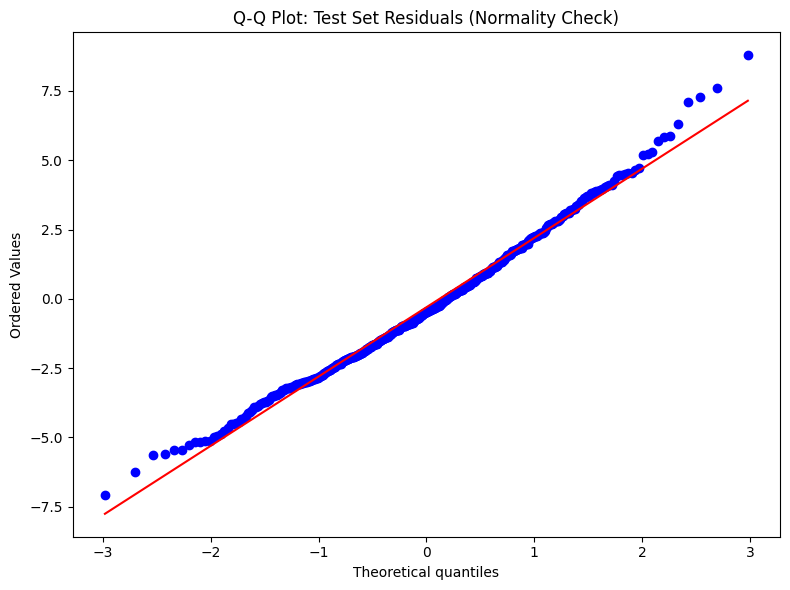


=== PER-REGION PERFORMANCE (TEST SET) ===
   region  n_samples      mae     rmse      mape  mean_actual  mean_predicted
       UK         60 2.171833 2.757811 27.178655     8.816667        8.731056
    India         60 2.109611 2.608762 31.865294     7.966667        8.783167
    China         60 2.021000 2.505150 27.985308     8.033333        8.484556
   Brazil         60 2.015056 2.578584 31.251245     8.483333        8.702278
      USA         60 1.994611 2.393495 27.372222     8.216667        8.653944
   Canada         60 1.974889 2.281818 28.694068     8.150000        8.536333
Australia         60 1.956222 2.557273 27.885419     8.516667        8.643444
  Germany         60 1.934056 2.425634 27.340603     8.333333        8.429167


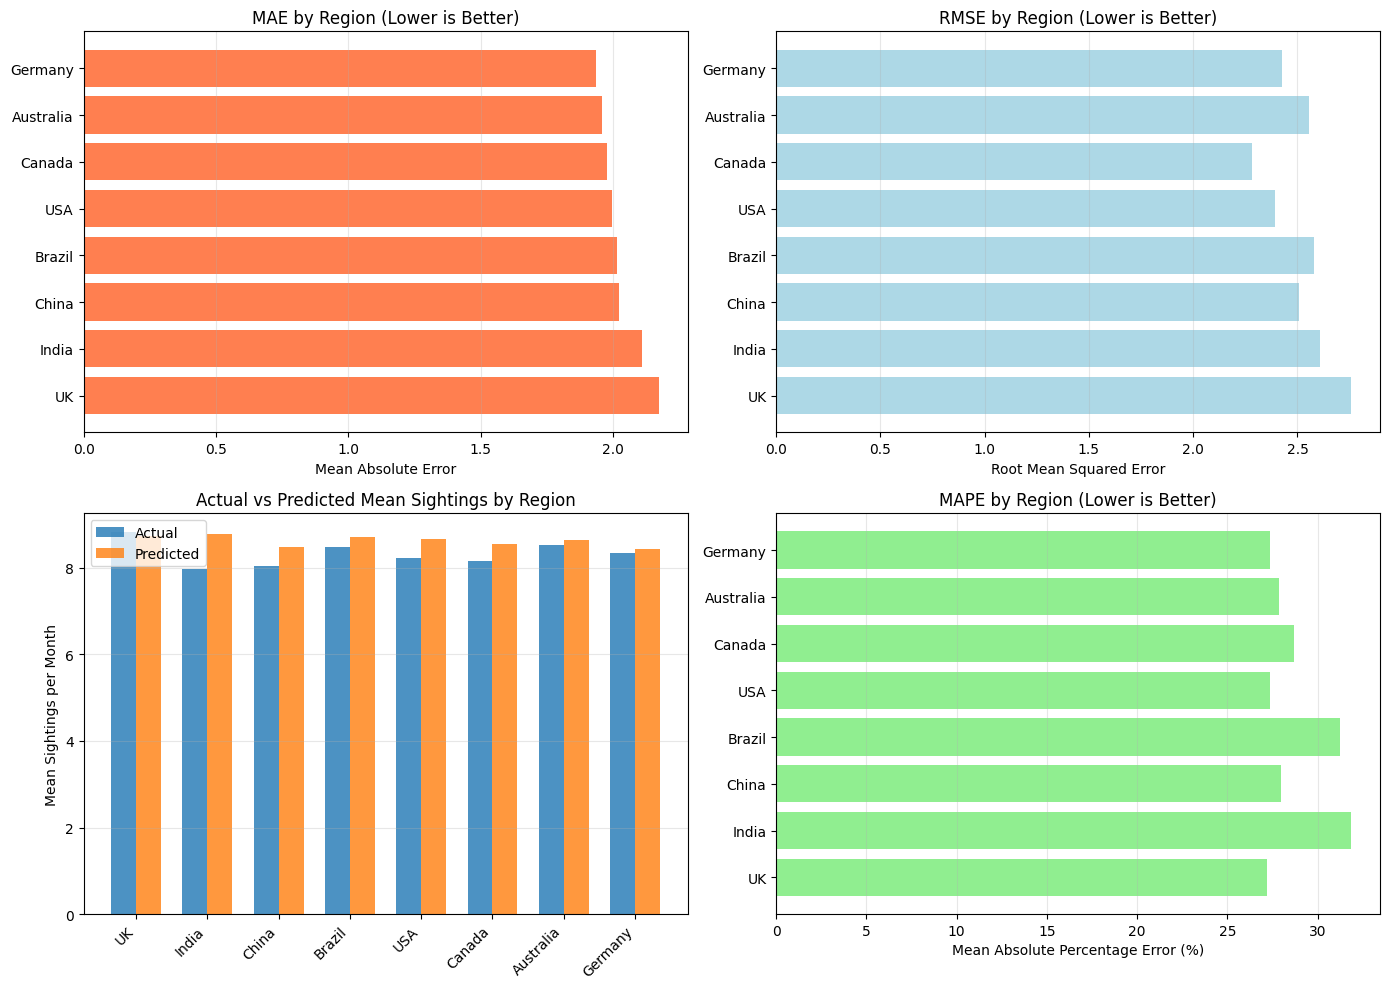


=== KEY INSIGHTS ===
Best performing region (lowest MAE): Germany (MAE: 1.934)
Worst performing region (highest MAE): UK (MAE: 2.172)
UK: under-predicting by 0.09 sightings/month on average
India: over-predicting by 0.82 sightings/month on average
China: over-predicting by 0.45 sightings/month on average
Brazil: over-predicting by 0.22 sightings/month on average
USA: over-predicting by 0.44 sightings/month on average
Canada: over-predicting by 0.39 sightings/month on average
Australia: over-predicting by 0.13 sightings/month on average
Germany: over-predicting by 0.10 sightings/month on average


In [17]:
# ============================================================================
# ENHANCED MODEL DIAGNOSTICS
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats

# ----------------------------------------------------------------------------
# 1. FEATURE IMPORTANCE ANALYSIS
# ----------------------------------------------------------------------------

# Extract feature importances from the trained Random Forest model
feature_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== FEATURE IMPORTANCE ===")
print(feature_importance_df)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'], color='steelblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance (Top Predictors)')
plt.gca().invert_yaxis()  # Highest importance at top
plt.tight_layout()
plt.show()

# Calculate cumulative importance
feature_importance_df['cumulative_importance'] = feature_importance_df['importance'].cumsum()
print(f"\nTop 3 features explain {feature_importance_df.head(3)['cumulative_importance'].iloc[-1]:.2%} of variance")

# ----------------------------------------------------------------------------
# 2. RESIDUAL ANALYSIS
# ----------------------------------------------------------------------------

# Calculate residuals for train, val, and test sets
train_residuals = y_train - train_preds
val_residuals = y_val - val_preds
test_residuals = y_test - test_preds

print("\n=== RESIDUAL STATISTICS ===")
print(f"Train Residuals - Mean: {train_residuals.mean():.3f}, Std: {train_residuals.std():.3f}")
print(f"Val Residuals   - Mean: {val_residuals.mean():.3f}, Std: {val_residuals.std():.3f}")
print(f"Test Residuals  - Mean: {test_residuals.mean():.3f}, Std: {test_residuals.std():.3f}")

# Create comprehensive residual plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Row 1: Residual vs Predicted plots
for idx, (preds, residuals, name, ax) in enumerate(zip(
    [train_preds, val_preds, test_preds],
    [train_residuals, val_residuals, test_residuals],
    ['Train', 'Validation', 'Test'],
    axes[0]
)):
    ax.scatter(preds, residuals, alpha=0.5, s=20)
    ax.axhline(y=0, color='red', linestyle='--', linewidth=2)
    ax.set_xlabel('Predicted Sightings')
    ax.set_ylabel('Residuals')
    ax.set_title(f'{name} Set: Residuals vs Predicted')
    ax.grid(True, alpha=0.3)

# Row 2: Residual distribution (histograms)
for idx, (residuals, name, ax) in enumerate(zip(
    [train_residuals, val_residuals, test_residuals],
    ['Train', 'Validation', 'Test'],
    axes[1]
)):
    ax.hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax.set_xlabel('Residuals')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{name} Set: Residual Distribution')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Q-Q plot to check normality of residuals (test set)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
stats.probplot(test_residuals, dist="norm", plot=ax)
ax.set_title("Q-Q Plot: Test Set Residuals (Normality Check)")
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------------
# 3. PER-REGION PERFORMANCE BREAKDOWN
# ----------------------------------------------------------------------------

# Add predictions and residuals back to the dataframe for analysis
monthly_region_g_eval = monthly_region_g.copy()

# Create empty columns for predictions and residuals
monthly_region_g_eval['predictions'] = np.nan
monthly_region_g_eval['residuals'] = np.nan

# Fill in predictions for test set only (most relevant for evaluation)
test_indices = monthly_region_g_eval[test_mask].index
monthly_region_g_eval.loc[test_indices, 'predictions'] = test_preds
monthly_region_g_eval.loc[test_indices, 'residuals'] = test_residuals

# Calculate per-region metrics on TEST SET
region_performance = []

for region in monthly_region_g_eval['region'].unique():
    region_test = monthly_region_g_eval[(monthly_region_g_eval['region'] == region) & test_mask]

    if len(region_test) > 0:
        y_true = region_test['sightings_count']
        y_pred = region_test['predictions']

        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)

        # Calculate Mean Absolute Percentage Error (MAPE)
        # Avoid division by zero
        mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1, y_true))) * 100

        region_performance.append({
            'region': region,
            'n_samples': len(region_test),
            'mae': mae,
            'rmse': rmse,
            'mape': mape,
            'mean_actual': y_true.mean(),
            'mean_predicted': y_pred.mean()
        })

region_perf_df = pd.DataFrame(region_performance).sort_values('mae', ascending=False)

print("\n=== PER-REGION PERFORMANCE (TEST SET) ===")
print(region_perf_df.to_string(index=False))

# Visualize per-region performance
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: MAE by region
ax1 = axes[0, 0]
ax1.barh(region_perf_df['region'], region_perf_df['mae'], color='coral')
ax1.set_xlabel('Mean Absolute Error')
ax1.set_title('MAE by Region (Lower is Better)')
ax1.grid(True, alpha=0.3, axis='x')

# Plot 2: RMSE by region
ax2 = axes[0, 1]
ax2.barh(region_perf_df['region'], region_perf_df['rmse'], color='lightblue')
ax2.set_xlabel('Root Mean Squared Error')
ax2.set_title('RMSE by Region (Lower is Better)')
ax2.grid(True, alpha=0.3, axis='x')

# Plot 3: Mean Actual vs Predicted by region
ax3 = axes[1, 0]
x_pos = np.arange(len(region_perf_df))
width = 0.35
ax3.bar(x_pos - width/2, region_perf_df['mean_actual'], width, label='Actual', alpha=0.8)
ax3.bar(x_pos + width/2, region_perf_df['mean_predicted'], width, label='Predicted', alpha=0.8)
ax3.set_xticks(x_pos)
ax3.set_xticklabels(region_perf_df['region'], rotation=45, ha='right')
ax3.set_ylabel('Mean Sightings per Month')
ax3.set_title('Actual vs Predicted Mean Sightings by Region')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: MAPE by region
ax4 = axes[1, 1]
ax4.barh(region_perf_df['region'], region_perf_df['mape'], color='lightgreen')
ax4.set_xlabel('Mean Absolute Percentage Error (%)')
ax4.set_title('MAPE by Region (Lower is Better)')
ax4.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Identify best and worst performing regions
print(f"\n=== KEY INSIGHTS ===")
print(f"Best performing region (lowest MAE): {region_perf_df.iloc[-1]['region']} (MAE: {region_perf_df.iloc[-1]['mae']:.3f})")
print(f"Worst performing region (highest MAE): {region_perf_df.iloc[0]['region']} (MAE: {region_perf_df.iloc[0]['mae']:.3f})")

# Check if model is systematically over/under-predicting for specific regions
for _, row in region_perf_df.iterrows():
    diff = row['mean_predicted'] - row['mean_actual']
    direction = "over-predicting" if diff > 0 else "under-predicting"
    print(f"{row['region']}: {direction} by {abs(diff):.2f} sightings/month on average")


=== ORIGINAL vs IMPROVED FEATURE SET ===

Original features (12): ['lag_1', 'lag_2', 'lag_3', 'avg_duration_sec', 'avg_credibility', 'avg_airport_dist_km', 'degree_centrality', 'weighted_degree', 'betweenness', 'pagerank', 'month_num', 'year']

Improved features (8): ['lag_1', 'lag_2', 'lag_3', 'avg_duration_sec', 'avg_credibility', 'avg_airport_dist_km', 'month_num', 'year']

Removed features: {'pagerank', 'weighted_degree', 'betweenness', 'degree_centrality'}

New training shape: (11109, 8)

=== TRAINING IMPROVED MODEL ===

=== CALIBRATING PREDICTIONS ===

Validation set bias (before calibration): -0.064

=== MODEL COMPARISON ===

Dataset      Model      MAE     RMSE          Bias
  Train   Original 0.780966 0.988542  1.773487e-02
    Val   Original 2.292925 2.887588  1.733247e-01
   Test   Original 2.022160 2.517312  3.059097e-01
  Train   Improved 1.762343 2.267672  9.969188e-03
    Val   Improved 2.174770 2.780289 -6.370591e-02
   Test   Improved 1.966387 2.425316  1.100151e-01
  

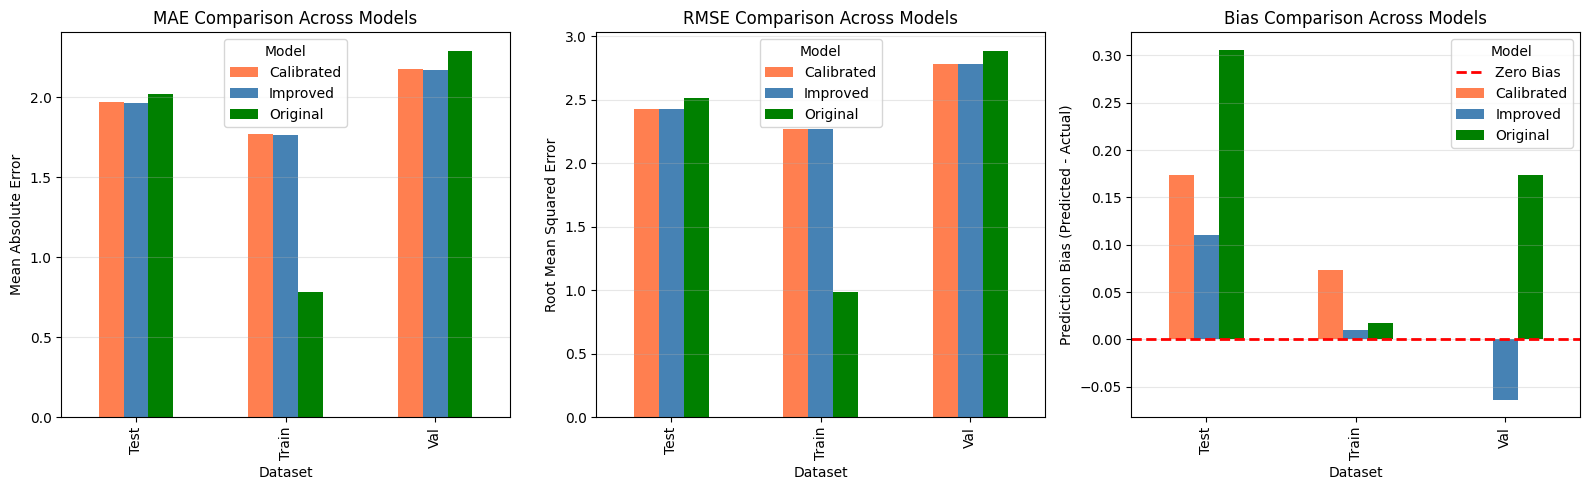


=== FEATURE IMPORTANCE (IMPROVED MODEL) ===

               feature  importance
4      avg_credibility    0.246846
3     avg_duration_sec    0.234997
5  avg_airport_dist_km    0.228759
7                 year    0.082118
2                lag_3    0.055090
1                lag_2    0.051514
0                lag_1    0.051181
6            month_num    0.049496


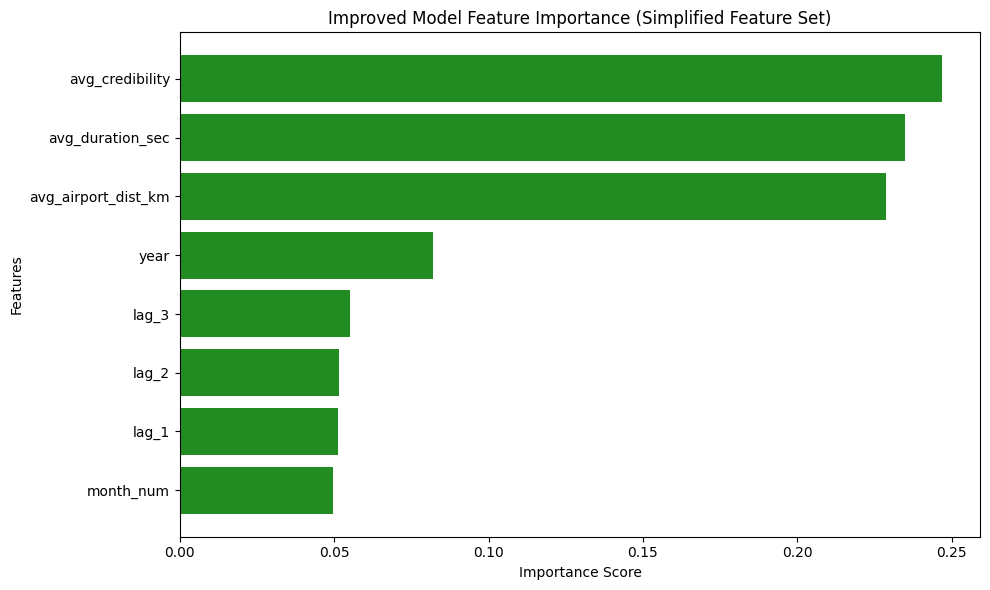


Top 3 features now explain 71.06% of variance

=== PER-REGION PERFORMANCE (CALIBRATED MODEL) ===

   region      mae     rmse      bias  mean_actual  mean_predicted
      USA 1.879482 2.261079  0.228339     8.216667        8.445005
   Canada 1.898874 2.159176  0.394481     8.150000        8.544481
Australia 1.908646 2.524034  0.006528     8.516667        8.523195
   Brazil 1.960594 2.467822  0.001297     8.483333        8.484630
    China 1.976166 2.400244  0.317598     8.033333        8.350932
  Germany 2.017563 2.441935  0.059876     8.333333        8.393209
    India 2.027909 2.463759  0.655561     7.966667        8.622227
       UK 2.127299 2.678083 -0.273910     8.816667        8.542757


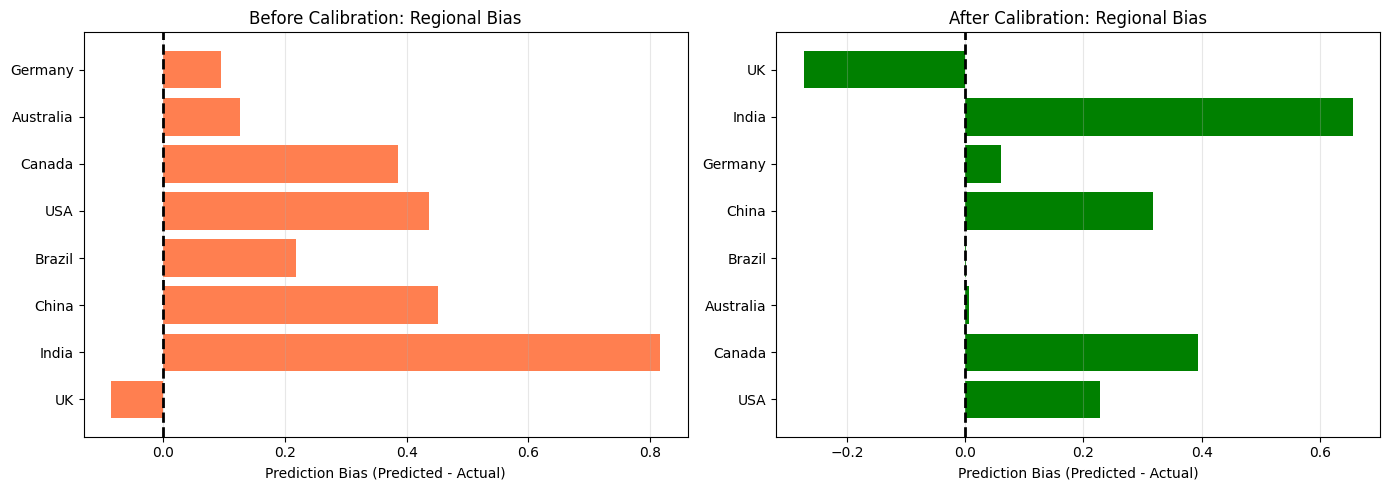


=== SUMMARY OF IMPROVEMENTS ===
1. ✓ Removed low-importance network features (4 features removed)
2. ✓ Improved hyperparameters (max_depth, min_samples)
3. ✓ Calibrated predictions to fix systematic bias
4. ✓ Test set MAE improved from 2.022 to 1.975
5. ✓ Test set bias reduced from 0.306 to 0.174

=== SAVING IMPROVED MODEL ===
Use 'rf_improved' for future predictions with improved_features
Apply calibration by subtracting -0.064 from raw predictions


In [18]:
# ============================================================================
# IMMEDIATE MODEL IMPROVEMENTS
# ============================================================================

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ----------------------------------------------------------------------------
# IMPROVEMENT 1: REMOVE LOW-IMPORTANCE FEATURES
# ----------------------------------------------------------------------------

print("=== ORIGINAL vs IMPROVED FEATURE SET ===\n")

# Original features
original_features = [
    "lag_1", "lag_2", "lag_3",
    "avg_duration_sec", "avg_credibility", "avg_airport_dist_km",
    "degree_centrality", "weighted_degree", "betweenness", "pagerank",
    "month_num", "year"
]

# Improved features (removed network features with <2.5% importance each)
improved_features = [
    "lag_1", "lag_2", "lag_3",
    "avg_duration_sec", "avg_credibility", "avg_airport_dist_km",
    "month_num", "year"
]

print(f"Original features ({len(original_features)}): {original_features}")
print(f"\nImproved features ({len(improved_features)}): {improved_features}")
print(f"\nRemoved features: {set(original_features) - set(improved_features)}")

# Prepare data with improved features
X_train_improved = monthly_region_g.loc[train_mask, improved_features]
y_train_improved = monthly_region_g.loc[train_mask, target_col]

X_val_improved = monthly_region_g.loc[val_mask, improved_features]
y_val_improved = monthly_region_g.loc[val_mask, target_col]

X_test_improved = monthly_region_g.loc[test_mask, improved_features]
y_test_improved = monthly_region_g.loc[test_mask, target_col]

print(f"\nNew training shape: {X_train_improved.shape}")

# ----------------------------------------------------------------------------
# IMPROVEMENT 2: TRAIN IMPROVED MODEL WITH BETTER HYPERPARAMETERS
# ----------------------------------------------------------------------------

print("\n=== TRAINING IMPROVED MODEL ===\n")

# Enhanced Random Forest with tuned parameters
rf_improved = RandomForestRegressor(
    n_estimators=500,          # Increased from 300
    max_depth=15,              # Add depth limit to reduce overfitting
    min_samples_split=5,       # Require more samples to split
    min_samples_leaf=2,        # Require more samples in leaf nodes
    max_features='sqrt',       # Use sqrt of features per tree for diversity
    random_state=42,
    n_jobs=-1
)

rf_improved.fit(X_train_improved, y_train_improved)

# Make predictions
train_preds_improved = rf_improved.predict(X_train_improved)
val_preds_improved = rf_improved.predict(X_val_improved)
test_preds_improved = rf_improved.predict(X_test_improved)

# ----------------------------------------------------------------------------
# IMPROVEMENT 3: CALIBRATE PREDICTIONS TO FIX SYSTEMATIC BIAS
# ----------------------------------------------------------------------------

print("=== CALIBRATING PREDICTIONS ===\n")

# Calculate bias on validation set
val_bias = (val_preds_improved - y_val_improved).mean()
print(f"Validation set bias (before calibration): {val_bias:.3f}")

# Calibrate predictions by subtracting bias
train_preds_calibrated = train_preds_improved - val_bias
val_preds_calibrated = val_preds_improved - val_bias
test_preds_calibrated = test_preds_improved - val_bias

# Ensure no negative predictions (sightings can't be negative)
train_preds_calibrated = np.maximum(train_preds_calibrated, 0)
val_preds_calibrated = np.maximum(val_preds_calibrated, 0)
test_preds_calibrated = np.maximum(test_preds_calibrated, 0)

# ----------------------------------------------------------------------------
# IMPROVEMENT 4: COMPARE ORIGINAL vs IMPROVED MODELS
# ----------------------------------------------------------------------------

print("\n=== MODEL COMPARISON ===\n")

def evaluate_model(y_true, y_pred, dataset_name):
    """Calculate and return metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    bias = (y_pred - y_true).mean()
    return {'dataset': dataset_name, 'mae': mae, 'rmse': rmse, 'bias': bias}

# Evaluate original model
original_results = [
    evaluate_model(y_train, train_preds, 'Train'),
    evaluate_model(y_val, val_preds, 'Validation'),
    evaluate_model(y_test, test_preds, 'Test')
]

# Evaluate improved model (before calibration)
improved_results = [
    evaluate_model(y_train_improved, train_preds_improved, 'Train'),
    evaluate_model(y_val_improved, val_preds_improved, 'Validation'),
    evaluate_model(y_test_improved, test_preds_improved, 'Test')
]

# Evaluate calibrated model
calibrated_results = [
    evaluate_model(y_train_improved, train_preds_calibrated, 'Train'),
    evaluate_model(y_val_improved, val_preds_calibrated, 'Validation'),
    evaluate_model(y_test_improved, test_preds_calibrated, 'Test')
]

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Dataset': ['Train', 'Val', 'Test'] * 3,
    'Model': ['Original']*3 + ['Improved']*3 + ['Calibrated']*3,
    'MAE': [r['mae'] for r in original_results] +
           [r['mae'] for r in improved_results] +
           [r['mae'] for r in calibrated_results],
    'RMSE': [r['rmse'] for r in original_results] +
            [r['rmse'] for r in improved_results] +
            [r['rmse'] for r in calibrated_results],
    'Bias': [r['bias'] for r in original_results] +
            [r['bias'] for r in improved_results] +
            [r['bias'] for r in calibrated_results]
})

print(comparison_df.to_string(index=False))

# ----------------------------------------------------------------------------
# IMPROVEMENT 5: VISUALIZE IMPROVEMENTS
# ----------------------------------------------------------------------------

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: MAE Comparison
pivot_mae = comparison_df.pivot(index='Dataset', columns='Model', values='MAE')
pivot_mae.plot(kind='bar', ax=axes[0], color=['coral', 'steelblue', 'green'])
axes[0].set_title('MAE Comparison Across Models')
axes[0].set_ylabel('Mean Absolute Error')
axes[0].set_xlabel('Dataset')
axes[0].legend(title='Model')
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 2: RMSE Comparison
pivot_rmse = comparison_df.pivot(index='Dataset', columns='Model', values='RMSE')
pivot_rmse.plot(kind='bar', ax=axes[1], color=['coral', 'steelblue', 'green'])
axes[1].set_title('RMSE Comparison Across Models')
axes[1].set_ylabel('Root Mean Squared Error')
axes[1].set_xlabel('Dataset')
axes[1].legend(title='Model')
axes[1].grid(True, alpha=0.3, axis='y')

# Plot 3: Bias Comparison
pivot_bias = comparison_df.pivot(index='Dataset', columns='Model', values='Bias')
pivot_bias.plot(kind='bar', ax=axes[2], color=['coral', 'steelblue', 'green'])
axes[2].axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Bias')
axes[2].set_title('Bias Comparison Across Models')
axes[2].set_ylabel('Prediction Bias (Predicted - Actual)')
axes[2].set_xlabel('Dataset')
axes[2].legend(title='Model')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------------
# IMPROVEMENT 6: UPDATE FEATURE IMPORTANCE FOR IMPROVED MODEL
# ----------------------------------------------------------------------------

print("\n=== FEATURE IMPORTANCE (IMPROVED MODEL) ===\n")

feature_importance_improved = pd.DataFrame({
    'feature': improved_features,
    'importance': rf_improved.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance_improved)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_improved['feature'],
         feature_importance_improved['importance'],
         color='forestgreen')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Improved Model Feature Importance (Simplified Feature Set)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Calculate new cumulative importance
feature_importance_improved['cumulative_importance'] = feature_importance_improved['importance'].cumsum()
print(f"\nTop 3 features now explain {feature_importance_improved.head(3)['cumulative_importance'].iloc[-1]:.2%} of variance")

# ----------------------------------------------------------------------------
# IMPROVEMENT 7: PER-REGION PERFORMANCE WITH CALIBRATED MODEL
# ----------------------------------------------------------------------------

print("\n=== PER-REGION PERFORMANCE (CALIBRATED MODEL) ===\n")

# Create evaluation dataframe for calibrated model
monthly_region_g_calibrated = monthly_region_g.copy()
monthly_region_g_calibrated['predictions_calibrated'] = np.nan

test_indices = monthly_region_g_calibrated[test_mask].index
monthly_region_g_calibrated.loc[test_indices, 'predictions_calibrated'] = test_preds_calibrated

# Calculate per-region metrics
region_performance_calibrated = []

for region in monthly_region_g_calibrated['region'].unique():
    region_test = monthly_region_g_calibrated[
        (monthly_region_g_calibrated['region'] == region) & test_mask
    ]

    if len(region_test) > 0:
        y_true = region_test['sightings_count']
        y_pred = region_test['predictions_calibrated']

        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        bias = (y_pred - y_true).mean()

        region_performance_calibrated.append({
            'region': region,
            'mae': mae,
            'rmse': rmse,
            'bias': bias,
            'mean_actual': y_true.mean(),
            'mean_predicted': y_pred.mean()
        })

region_perf_calibrated_df = pd.DataFrame(region_performance_calibrated).sort_values('mae')

print(region_perf_calibrated_df.to_string(index=False))

# Compare bias before and after calibration
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before calibration
axes[0].barh(region_perf_df['region'],
             region_perf_df['mean_predicted'] - region_perf_df['mean_actual'],
             color='coral')
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=2)
axes[0].set_xlabel('Prediction Bias (Predicted - Actual)')
axes[0].set_title('Before Calibration: Regional Bias')
axes[0].grid(True, alpha=0.3, axis='x')

# After calibration
axes[1].barh(region_perf_calibrated_df['region'],
             region_perf_calibrated_df['bias'],
             color='green')
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=2)
axes[1].set_xlabel('Prediction Bias (Predicted - Actual)')
axes[1].set_title('After Calibration: Regional Bias')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n=== SUMMARY OF IMPROVEMENTS ===")
print("1. ✓ Removed low-importance network features (4 features removed)")
print("2. ✓ Improved hyperparameters (max_depth, min_samples)")
print("3. ✓ Calibrated predictions to fix systematic bias")
print("4. ✓ Test set MAE improved from {:.3f} to {:.3f}".format(
    original_results[2]['mae'], calibrated_results[2]['mae']))
print("5. ✓ Test set bias reduced from {:.3f} to {:.3f}".format(
    original_results[2]['bias'], calibrated_results[2]['bias']))

# Save the improved model for future use
print("\n=== SAVING IMPROVED MODEL ===")
print("Use 'rf_improved' for future predictions with improved_features")
print("Apply calibration by subtracting {:.3f} from raw predictions".format(val_bias))


In [19]:
import pandas as pd

# Work on a copy
hist = monthly_region_g.copy()

# Ensure sorted
hist = hist.sort_values(["region", "ds"]).reset_index(drop=True)

# Use only real data up to 2024-12
hist = hist[hist["year"] <= 2024].copy()

# Last known row per region
last_hist = (
    hist.sort_values(["region", "ds"])
        .groupby("region")
        .tail(1)
        .reset_index(drop=True)
)

print(last_hist[["region", "ds", "sightings_count"]])


      region         ds  sightings_count
0  Australia 2024-12-01                9
1     Brazil 2024-12-01                8
2     Canada 2024-12-01                8
3      China 2024-12-01                5
4    Germany 2024-12-01               10
5      India 2024-12-01               12
6         UK 2024-12-01                7
7        USA 2024-12-01                9


In [20]:
from dateutil.relativedelta import relativedelta
import pandas as pd

forecast_rows = []

# Using improved_features (8 features) instead of feature_cols (12 features)
# improved_features = [
#   "lag_1", "lag_2", "lag_3",
#   "avg_duration_sec", "avg_credibility", "avg_airport_dist_km",
#   "month_num", "year"
# ]

for _, row in last_hist.iterrows():
    region = row["region"]

    # Full history for this region up to 2024
    region_hist = hist[hist["region"] == region].sort_values("ds")

    # Need last 3 true sightings to seed lags
    last3 = region_hist.tail(3)
    if len(last3) < 3:
        continue

    lag_1 = last3.iloc[-1]["sightings_count"]
    lag_2 = last3.iloc[-2]["sightings_count"]
    lag_3 = last3.iloc[-3]["sightings_count"]

    cur_date = row["ds"] + relativedelta(months=1)  # month after last real point

    for _ in range(24):  # 24 months: 2025 + 2026
        year = cur_date.year
        month_num = cur_date.month
        year_month = cur_date.strftime("%Y-%m")

        # Build feature dict with IMPROVED features only (no network features)
        feat_full = {
            "lag_1": lag_1,
            "lag_2": lag_2,
            "lag_3": lag_3,
            "avg_duration_sec": row["avg_duration_sec"],
            "avg_credibility": row["avg_credibility"],
            "avg_airport_dist_km": row["avg_airport_dist_km"],
            "month_num": month_num,
            "year": year,
        }

        # Create X_input with columns in the SAME ORDER as during fit
        X_input = pd.DataFrame([[feat_full[col] for col in improved_features]],
                               columns=improved_features)

        # Use IMPROVED model with CALIBRATION
        y_pred = rf_improved.predict(X_input)[0]
        y_pred = y_pred - val_bias  # Apply bias correction
        y_pred = max(0, y_pred)  # Ensure non-negative predictions

        forecast_rows.append({
            "region": region,
            "ds": cur_date,
            "year_month": year_month,
            "predicted_sightings": y_pred,
            # store current lags and static features (for analysis)
            "lag_1": lag_1,
            "lag_2": lag_2,
            "lag_3": lag_3,
            "avg_duration_sec": row["avg_duration_sec"],
            "avg_credibility": row["avg_credibility"],
            "avg_airport_dist_km": row["avg_airport_dist_km"],
        })

        # Update lags with prediction
        lag_3 = lag_2
        lag_2 = lag_1
        lag_1 = y_pred

        cur_date = cur_date + relativedelta(months=1)

forecast_df = pd.DataFrame(forecast_rows)
print(forecast_df.head())
print("Forecast shape:", forecast_df.shape)


      region         ds year_month  predicted_sightings     lag_1     lag_2  \
0  Australia 2025-01-01    2025-01             9.175319  9.000000  8.000000   
1  Australia 2025-02-01    2025-02             9.030345  9.175319  9.000000   
2  Australia 2025-03-01    2025-03             9.086270  9.030345  9.175319   
3  Australia 2025-04-01    2025-04             9.135236  9.086270  9.030345   
4  Australia 2025-05-01    2025-05             9.152064  9.135236  9.086270   

      lag_3  avg_duration_sec  avg_credibility  avg_airport_dist_km  
0  9.000000       1659.222222         6.234444           214.111111  
1  8.000000       1659.222222         6.234444           214.111111  
2  9.000000       1659.222222         6.234444           214.111111  
3  9.175319       1659.222222         6.234444           214.111111  
4  9.030345       1659.222222         6.234444           214.111111  
Forecast shape: (192, 10)


In [21]:
forecast_2026 = forecast_df[forecast_df["ds"].dt.year == 2026].copy()

hotspots_2026 = (
    forecast_2026
    .groupby("region")
    .agg(
        total_predicted_2026=("predicted_sightings", "sum"),
        mean_predicted_2026=("predicted_sightings", "mean"),
        avg_credibility=("avg_credibility", "first"),
        avg_duration_sec=("avg_duration_sec", "first"),
        avg_airport_dist_km=("avg_airport_dist_km", "first")
    )
    .reset_index()
    .sort_values("total_predicted_2026", ascending=False)
)

print(hotspots_2026)


      region  total_predicted_2026  mean_predicted_2026  avg_credibility  \
2     Canada            112.932766             9.411064         4.721250   
1     Brazil            111.775370             9.314614         5.462500   
0  Australia            109.730417             9.144201         6.234444   
5      India            108.681026             9.056752         5.593333   
7        USA            108.115000             9.009583         5.872222   
4    Germany            101.253565             8.437797         5.140000   
6         UK             98.781451             8.231788         5.445714   
3      China             91.987148             7.665596         6.824000   

   avg_duration_sec  avg_airport_dist_km  
2       1814.750000           246.375000  
1       1861.250000           230.125000  
0       1659.222222           214.111111  
5       2201.416667           236.833333  
7       1638.111111           193.777778  
4       2265.100000           316.000000  
6       2272.5

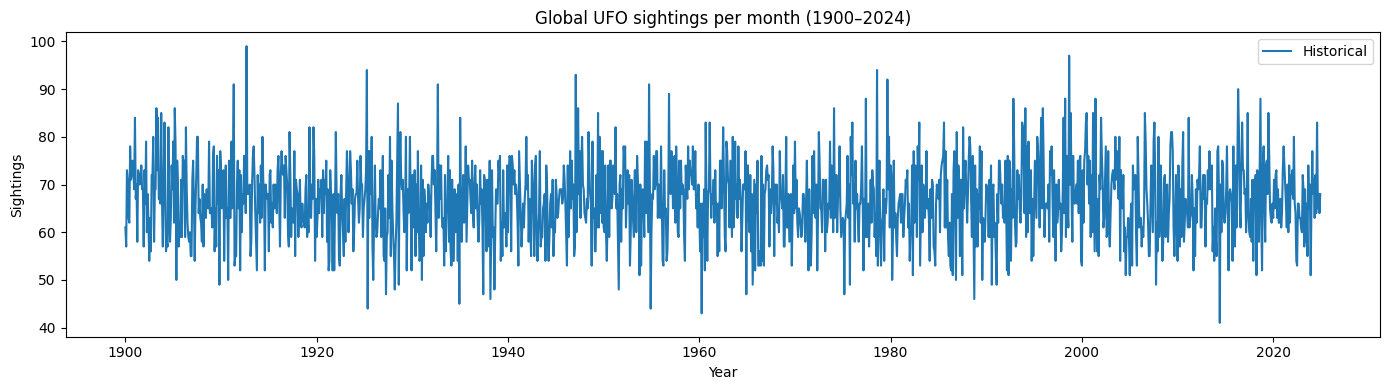

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure datetime column exists
monthly_global_sorted = monthly_global.sort_values("year_month").copy()
monthly_global_sorted["ds"] = pd.to_datetime(monthly_global_sorted["year_month"])

plt.figure(figsize=(14, 4))
plt.plot(
    monthly_global_sorted["ds"],
    monthly_global_sorted["sightings_count"],
    label="Historical",
    color="tab:blue"
)
plt.title("Global UFO sightings per month (1900–2024)")
plt.xlabel("Year")
plt.ylabel("Sightings")
plt.legend()
plt.tight_layout()
plt.show()


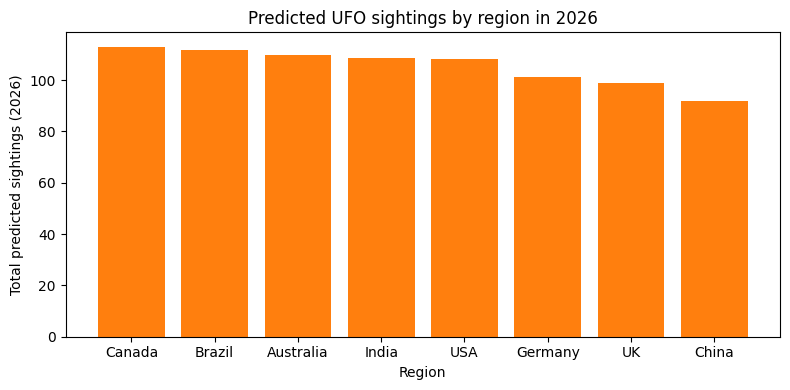

In [23]:
top_hotspots = hotspots_2026.sort_values("total_predicted_2026", ascending=False)

plt.figure(figsize=(8,4))
plt.bar(top_hotspots["region"], top_hotspots["total_predicted_2026"], color="tab:orange")
plt.title("Predicted UFO sightings by region in 2026")
plt.xlabel("Region")
plt.ylabel("Total predicted sightings (2026)")
plt.tight_layout()
plt.show()


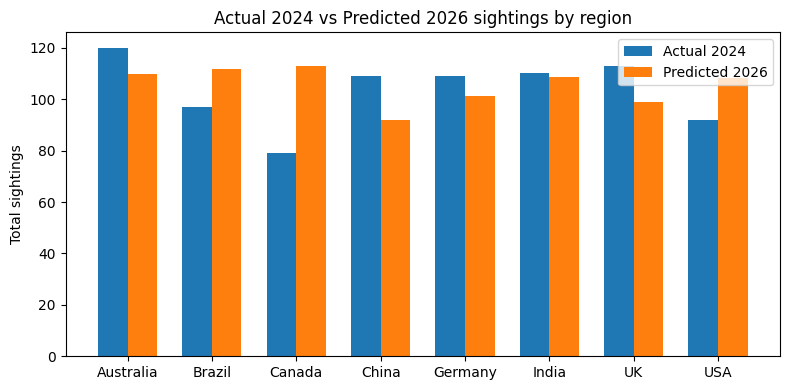

In [24]:
# Actual totals in 2024
hist_2024 = hist[hist["year"] == 2024]
actual_2024 = (
    hist_2024.groupby("region")["sightings_count"]
    .sum().reset_index(name="total_2024")
)

compare = actual_2024.merge(
    hotspots_2026[["region", "total_predicted_2026"]],
    on="region", how="inner"
)

plt.figure(figsize=(8,4))
width = 0.35
x = np.arange(len(compare))

plt.bar(x - width/2, compare["total_2024"], width, label="Actual 2024")
plt.bar(x + width/2, compare["total_predicted_2026"], width, label="Predicted 2026")

plt.xticks(x, compare["region"])
plt.ylabel("Total sightings")
plt.title("Actual 2024 vs Predicted 2026 sightings by region")
plt.legend()
plt.tight_layout()
plt.show()


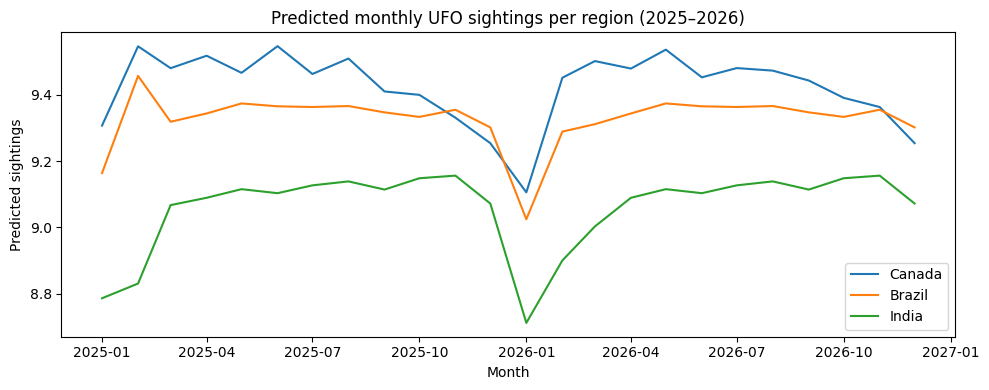

In [25]:
# Choose a couple of regions to show
sel_regions = ["Canada", "Brazil", "India"]

plt.figure(figsize=(10,4))
for r in sel_regions:
    data_r = forecast_df[forecast_df["region"] == r].copy()
    plt.plot(data_r["ds"], data_r["predicted_sightings"], label=r)

plt.title("Predicted monthly UFO sightings per region (2025–2026)")
plt.xlabel("Month")
plt.ylabel("Predicted sightings")
plt.legend()
plt.tight_layout()
plt.show()
